<a href="https://colab.research.google.com/github/omerbokobza/GSP_PROJECT/blob/main/FinalProjectGSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries and initialization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import pywt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
! pip install torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, TopKPooling, BatchNorm
import torch.nn.functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Natural Gas System Model Implementations**

In [ ]:
# Number of nodes in the graph
n_nodes = 20

# Create a random connected graph
G = nx.erdos_renyi_graph(n_nodes,0.21)
pos = nx.spring_layout(G)  # positions for all nodes

# True pressures and flows
true_pressures = abs(np.random.randn(n_nodes)) # Pressure in psi
true_flows = np.random.randn(n_nodes)     # Flow in m^3/h

# Combine pressures and flows into a single state matrix
true_states = np.vstack((true_pressures, true_flows))

**Adding Noise ~ $N(0,1)$**

**Implementation of the Weighted Low Rank Approximation**

In [ ]:
# Function to add noise based on SNR
def add_noise_based_on_snr(signal, snr_db):
    """ Adds noise to the signal based on the specified SNR in dB. """
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise
# Function to add Gaussian noise to measurements

# Function to perform weighted low-rank approximation
def weighted_low_rank_approximation(data, rank=2, max_iter=50):
    m, n = data.shape
    U = np.random.rand(m, rank) #uniform
    V = np.random.rand(rank, n)

    for _ in range(max_iter):
        V = np.linalg.lstsq(U, data, rcond=None)[0]
        U = np.linalg.lstsq(V.T, data.T, rcond=None)[0].T

    return U @ V

In [ ]:
# Noisy measurements
noisy_measurements = add_noise_based_on_snr(true_states,10)
# Estimate the states using the approximation
estimated_states = weighted_low_rank_approximation(noisy_measurements)

# Calculate MSE
mse = np.mean((true_states - estimated_states)**2)

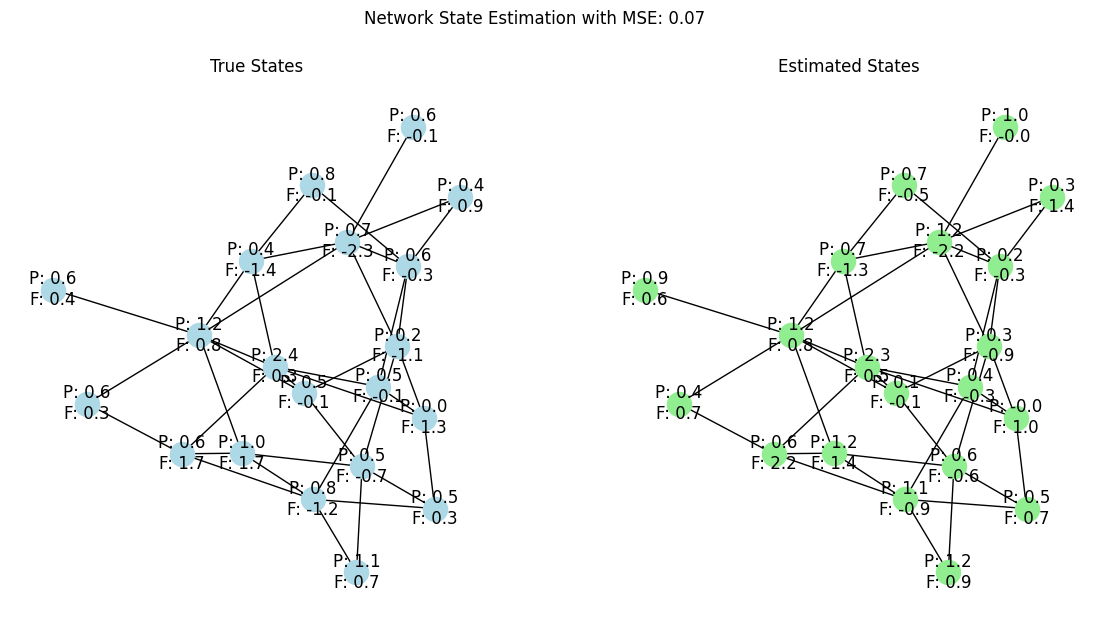

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot true and estimated states
labels_true = {i: f"P: {true_pressures[i]:.1f}\nF: {true_flows[i]:.1f}" for i in range(n_nodes)}
labels_estimated = {i: f"P: {estimated_states[0, i]:.1f}\nF: {estimated_states[1, i]:.1f}" for i in range(n_nodes)}

plt.subplot(1, 2, 1)
nx.draw(G, pos, with_labels=True, labels=labels_true, node_color='lightblue')
plt.title('True States')

plt.subplot(1, 2, 2)
nx.draw(G, pos, with_labels=True, labels=labels_estimated, node_color='lightgreen')
plt.title('Estimated States')

plt.suptitle(f'Network State Estimation with MSE: {mse:.2f}')
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/original_graph.pdf', bbox_inches='tight')
plt.show()


## EXAMPLE OF USAGE - FLOW IN EDGES, PRESSURE IN NODES

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)

# Number of nodes in the graph
n_nodes = 10

# Create a connected graph
while True:
    G = nx.gnp_random_graph(n_nodes, 0.5)
    if nx.is_connected(G):
        break
pos = nx.spring_layout(G)  # positions for all nodes

# Assign true pressures and flows
true_pressures = {node: abs(np.random.randn()) for node in G.nodes()}  # Pressure in bars
true_flows = {edge: abs(np.random.randn()) for edge in G.edges()}      # Flow in m³/s

# Combine pressures and flows into a single state vector
true_state_vector = np.hstack([list(true_pressures.values()), list(true_flows.values())])
# Noisy measurements
noisy_measurements = add_noise_based_on_snr(true_state_vector, 10)

# Function to perform simple low-rank approximation using SVD
def svd_low_rank_approximation(data, rank=2):
    U, S, Vt = np.linalg.svd(data, full_matrices=False)
    S[rank:] = 0  # truncate the singular values
    return U @ np.diag(S) @ Vt


In [ ]:
# Estimate the states using the approximation
estimated_state_vector = svd_low_rank_approximation(noisy_measurements.reshape(1, -1), rank=2).flatten()

# Parse back the estimated pressures and flows
estimated_pressures = dict(zip(G.nodes(), estimated_state_vector[:n_nodes]))
estimated_flows = dict(zip(G.edges(), estimated_state_vector[n_nodes:]))

# Calculate MSE
mse = np.mean((true_state_vector - estimated_state_vector) ** 2)

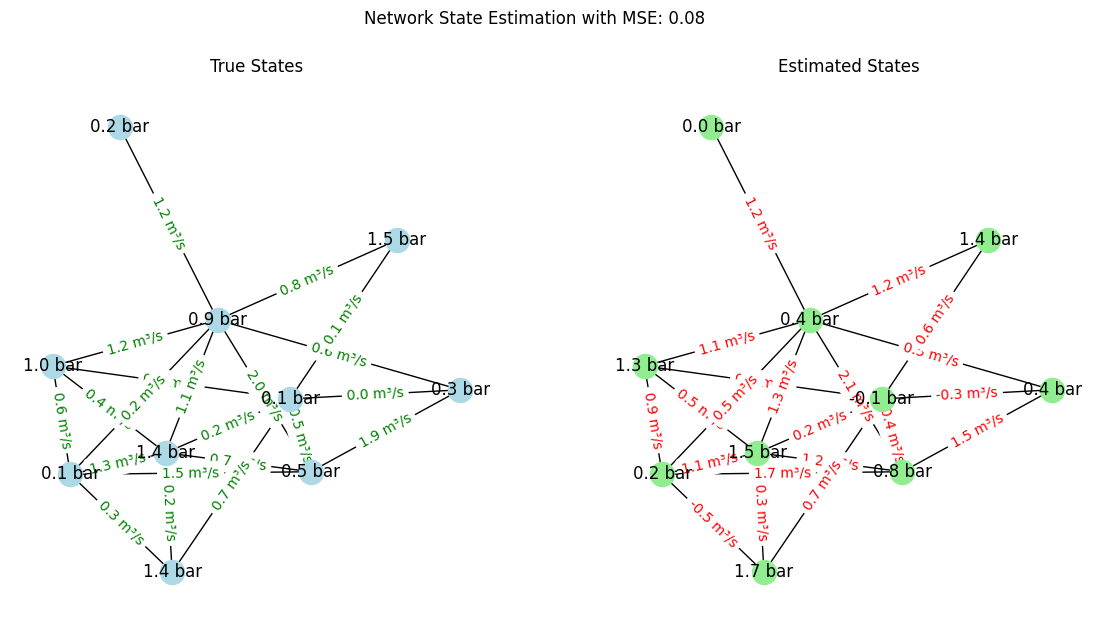

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))

# True state plot
plt.subplot(1, 2, 1)
labels_true = {i: f"{true_pressures[i]:.1f} bar" for i in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels_true, node_color='lightblue', edge_color='k')
nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{true_flows[e]:.1f} m³/s" for e in G.edges()}, font_color='green')
plt.title('True States')

# Estimated state plot
plt.subplot(1, 2, 2)
labels_estimated = {i: f"{estimated_pressures[i]:.1f} bar" for i in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels_estimated, node_color='lightgreen', edge_color='k')
nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{estimated_flows[e]:.1f} m³/s" for e in G.edges()}, font_color='red')
plt.title('Estimated States')

plt.suptitle(f'Network State Estimation with MSE: {mse:.2f}')

# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/original_graph2.pdf', bbox_inches='tight')

plt.show()

## continue with pressure in node and flow in nodes

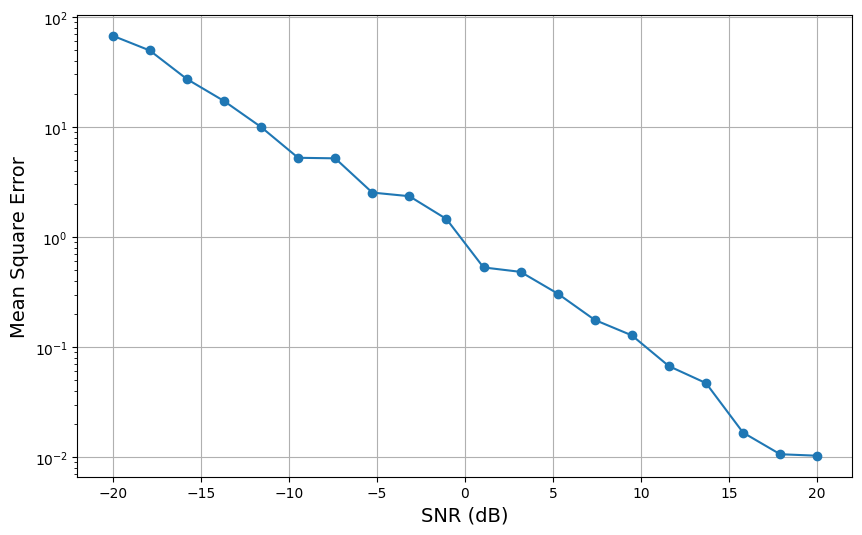

In [ ]:

# SNR levels to sweep
snr_levels = np.linspace(-20, 20, num=20)  # From 0 dB to 50 dB

# Initialize array to store MSEs
mses = []

# Process each SNR level
for snr in snr_levels:
    # Add noise to true states based on current SNR
    noisy_measurements = add_noise_based_on_snr(true_states, snr)

    # Estimate states using weighted low-rank approximation
    estimated_states = weighted_low_rank_approximation(noisy_measurements)

    # Calculate MSE and store it
    mse = np.mean((true_states - estimated_states)**2)
    mses.append(mse)

# Plotting MSE vs SNR
plt.figure(figsize=(10, 6))
# plt.plot(snr_levels, mses, marker='o', linestyle='-')
plt.semilogy(snr_levels,mses, marker='o', linestyle='-')
# plt.title('MSE vs SNR')
plt.xlabel('SNR (dB)',size=14)
plt.ylabel('Mean Square Error',size=14)
plt.grid(True)
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/original_graph_MSE_SNR.pdf', bbox_inches='tight')
plt.show()


## **Other Methods for dealing with the Noise**

***Wavelet Denoising -***

This function uses the wavelet transform to denoise a signal by decomposing it into wavelet coefficients, applying a threshold to eliminate noise, and then reconstructing the signal. It leverages the median absolute deviation to estimate noise levels and determine the threshold for noise reduction.

***Regularized low rank approximation -***

This function approximates a data matrix with a product of two lower-rank matrices, using regularization to avoid overfitting. It iteratively adjusts the matrices to minimize the reconstruction error, incorporating a regularization term to maintain stability and improve the conditioning of the solution.

***Kalman filter -***

The Kalman Filter function estimates the state of a linear dynamic system from a series of noisy measurements. It iteratively updates predictions based on a measurement and a model of system dynamics, adjusting estimates with a Kalman gain that minimizes the mean squared error of the estimated parameters.

In [ ]:
# Denoising Function using Wavelet Transform
def wavelet_denoising(signal, wavelet='db1', level=1):
    # Decompose to get the coefficients
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    # Estimate the noise sigma from the median absolute deviation of the highest level detail coefficients
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    # Apply threshold
    new_coeffs = [coeffs[0]] + [pywt.threshold(i, value=threshold, mode='soft') for i in coeffs[1:]]
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(new_coeffs, wavelet, mode='symmetric')


def regularized_low_rank_approx(data, rank=2, max_iter=100, lambda_reg=1):
    m, n = data.shape
    U = np.random.rand(m, rank)
    V = np.random.rand(n, rank)  # Note: Changing the shape of V to n x rank for correct alignment

    for _ in range(max_iter):
        # Update V, where U.T @ U + lambda_reg * I is rank x rank
        V = np.linalg.lstsq(U.T @ U + lambda_reg * np.eye(rank), U.T @ data, rcond=None)[0].T

        # Update U, where V.T @ V + lambda_reg * I is rank x rank
        U = np.linalg.lstsq(V.T @ V + lambda_reg * np.eye(rank), data @ V, rcond=None)[0]

    return U @ V.T  # Returning the multiplication of U and V.T for correct dimension alignment in data reconstruction

def kalman_filter(measurements, process_variance, measurement_variance, initial_estimate):
    num_samples, num_features = measurements.shape
    estimates = np.zeros_like(measurements)
    estimate = initial_estimate
    variance = np.full(num_features, process_variance)  # Initial high variance

    for i in range(num_samples):
        kalman_gain = variance / (variance + measurement_variance)
        estimate += kalman_gain * (measurements[i] - estimate)
        variance = (1 - kalman_gain) * variance
        estimates[i, :] = estimate

    return estimates


In [ ]:
# Main Experiment Function
def perform_experiment(snr_levels, true_states, method):
    mses = []
    for snr in snr_levels:
        noisy_measurements = add_noise_based_on_snr(true_states, snr)
        if method == 'wavelet':
            denoised_measurements = np.apply_along_axis(wavelet_denoising, 1, noisy_measurements)
            estimated_states = regularized_low_rank_approx(denoised_measurements)
        elif method == 'regularization':
            estimated_states = regularized_low_rank_approx(noisy_measurements)
        elif method == 'kalman':
            estimated_states = kalman_filter(noisy_measurements, 0.3, 1, 0)
        mse = np.mean((true_states - estimated_states)**2)
        mses.append(mse)
    return mses, estimated_states

In [ ]:
# Perform experiments
mses_wavelet,_ = perform_experiment(snr_levels, true_states, 'wavelet')
mses_regularization,_ = perform_experiment(snr_levels, true_states, 'regularization')
mses_kalman,_ = perform_experiment(snr_levels, true_states, 'kalman')

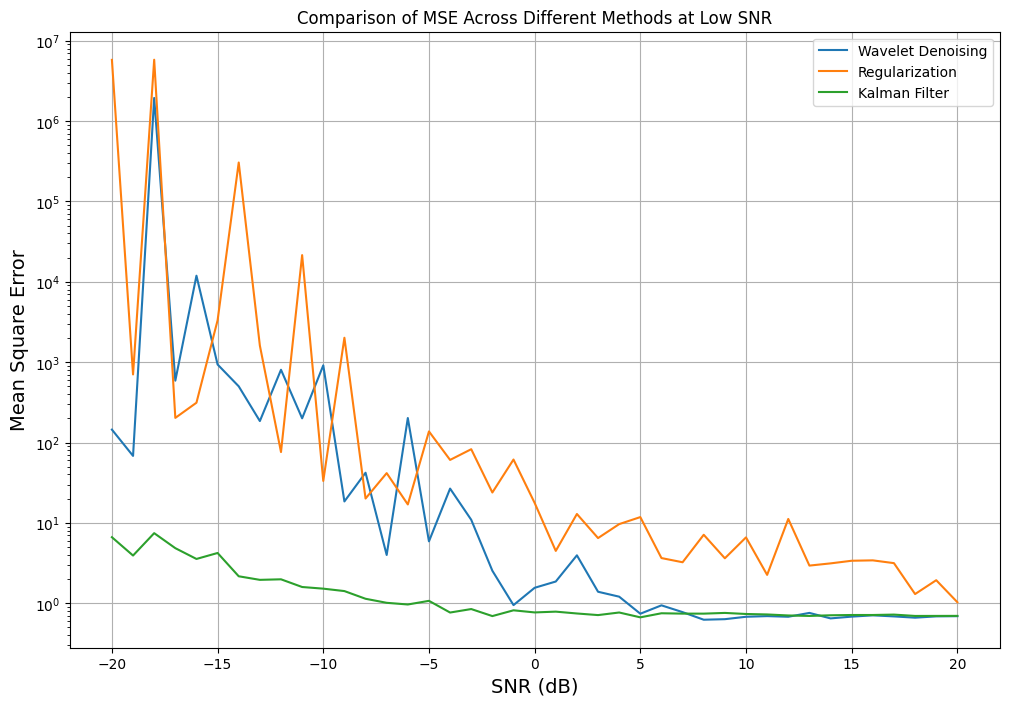

In [ ]:
# Plotting Results
plt.figure(figsize=(12, 8))
plt.semilogy(snr_levels, mses_wavelet, label='Wavelet Denoising')
plt.semilogy(snr_levels, mses_regularization, label='Regularization')
plt.semilogy(snr_levels, mses_kalman, label='Kalman Filter')
plt.xlabel('SNR (dB)', size = 14)
plt.ylabel('Mean Square Error',size = 14)
plt.title('Comparison of MSE Across Different Methods at Low SNR')
plt.legend()
plt.grid(True)
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/cmpr3models.pdf', bbox_inches='tight')
plt.show()

**Comparison between the Kalman filter model and the original low-rank model**

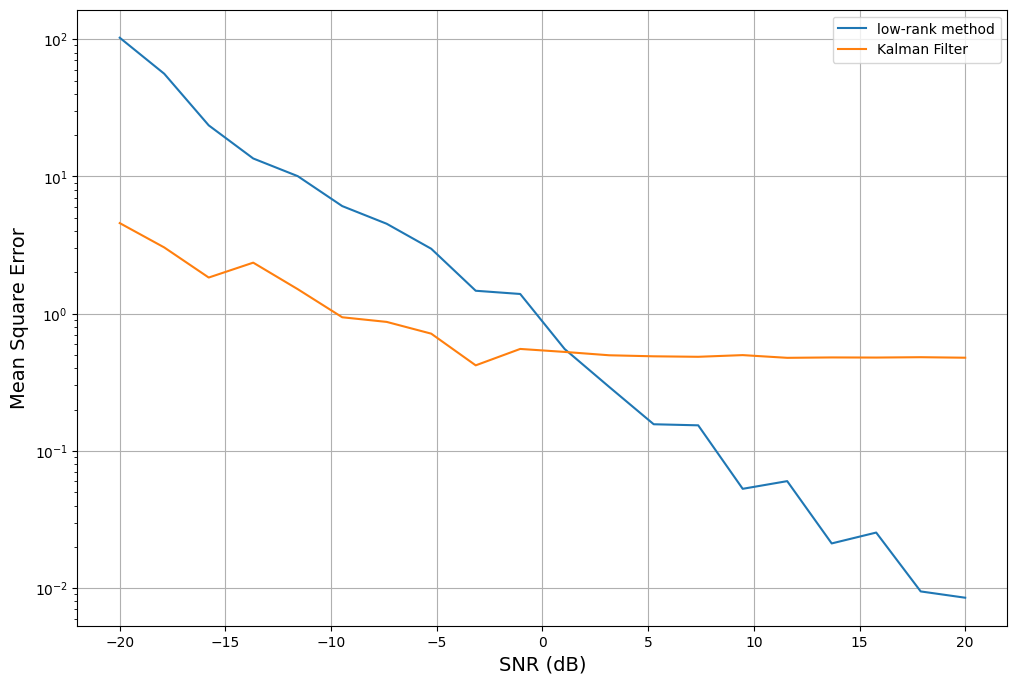

In [ ]:
plt.figure(figsize=(12, 8))
plt.semilogy(snr_levels, mses, label='low-rank method')
plt.semilogy(snr_levels, mses_kalman, label='Kalman Filter')
plt.xlabel('SNR (dB)', size = 14)
plt.ylabel('Mean Square Error', size = 14)
# plt.title('Comparison of MSE Across Different Methods in Low SNR condition')
plt.legend()
plt.grid(True)
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/cmprkalman.pdf', bbox_inches='tight')
plt.show()

**Examle of the graph after applying Kalman filter - the true states and the estimated states**

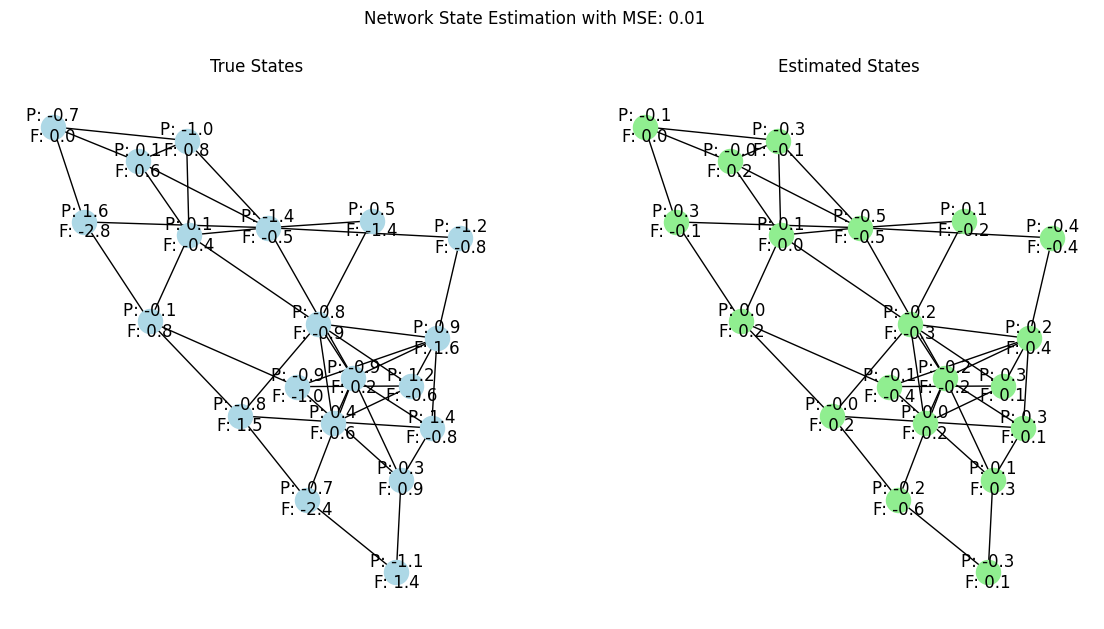

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))
_, estimated_states = perform_experiment([10], true_states, 'kalman')
# Plot true and estimated states
labels_true = {i: f"P: {true_pressures[i]:.1f}\nF: {true_flows[i]:.1f}" for i in range(n_nodes)}
labels_estimated = {i: f"P: {estimated_states[0, i]:.1f}\nF: {estimated_states[1, i]:.1f}" for i in range(n_nodes)}

plt.subplot(1, 2, 1)
nx.draw(G, pos, with_labels=True, labels=labels_true, node_color='lightblue')
plt.title('True States')

plt.subplot(1, 2, 2)
nx.draw(G, pos, with_labels=True, labels=labels_estimated, node_color='lightgreen')
plt.title('Estimated States')

plt.suptitle(f'Network State Estimation with MSE: {mse:.2f}')
plt.show()

# **PCA**

**Principal Component Analysis ($PCA$)** was employed as a potential enhancement to the original model with the aim of improving data representation by reducing dimensionality. However, the application of PCA did not significantly influence the outcomes. Consequently, this technique was not included in the final paper due to its minimal impact on the results.

Considerations:

**Information Loss:** While $PCA$ reduces dimensionality, this comes at the cost of losing some information, which might be crucial in some contexts.


**Assumption of Linearity:** $PCA$ assumes that the principal components are linear combinations of the original features, which might not always capture the complexities or non-linear relationships in the data.



In [ ]:
# Create a graph
n_nodes = 20
G = nx.erdos_renyi_graph(n_nodes, p = 0.3)
pos = nx.spring_layout(G)

# Generate true states
true_pressures = np.random.randn(n_nodes)
true_flows = np.random.randn(n_nodes)
true_states = np.vstack((true_pressures, true_flows))

# Standardize and apply PCA
scaler = StandardScaler()
true_states_scaled = scaler.fit_transform(true_states.T)
pca = PCA(n_components=2)  # Adjust based on explained variance needed
principal_components = pca.fit_transform(true_states_scaled)

In [ ]:
noisy_measurements = add_noise_based_on_snr(principal_components, 10)
estimated_states = weighted_low_rank_approximation(noisy_measurements)

# Transform back to original data space and ensure proper handling
estimated_states_pca = pca.inverse_transform(estimated_states)
reconstructed_estimates = scaler.inverse_transform(estimated_states_pca)

# Ensure the matrix is transposed back if necessary
reconstructed_estimates = reconstructed_estimates.T

# Calculate MSE
mse = np.mean((true_states - reconstructed_estimates)**2)

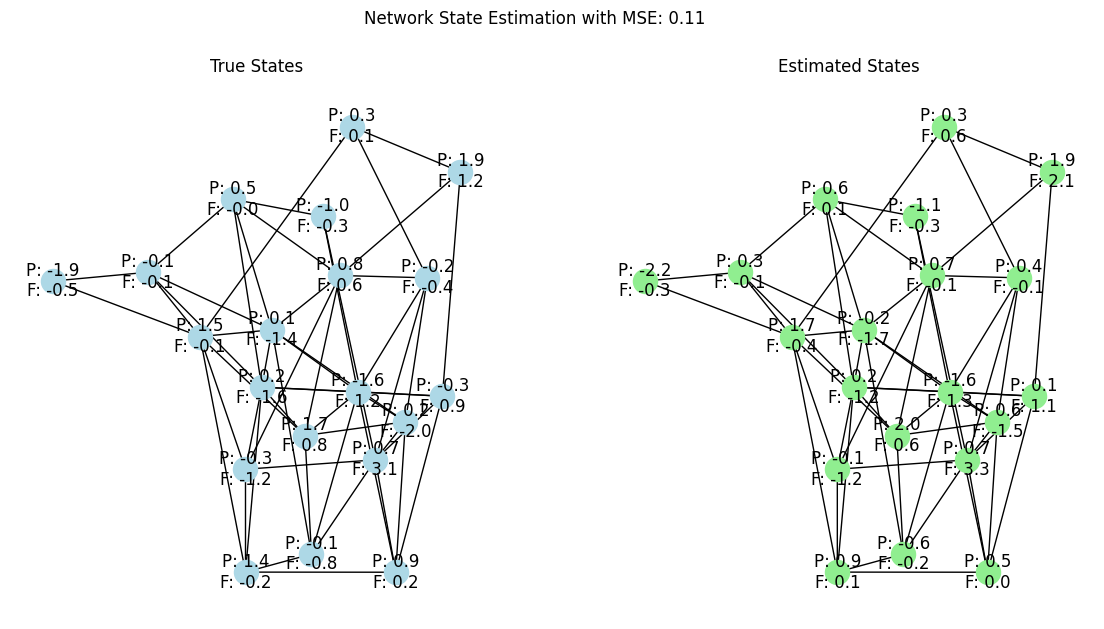

In [ ]:
# Visualization
plt.figure(figsize=(14, 7))
labels_true = {i: f"P: {true_pressures[i]:.1f}\nF: {true_flows[i]:.1f}" for i in range(n_nodes)}
labels_estimated = {i: f"P: {reconstructed_estimates[0, i]:.1f}\nF: {reconstructed_estimates[1, i]:.1f}" for i in range(n_nodes)}
plt.subplot(1, 2, 1)
nx.draw(G, pos, with_labels=True, labels=labels_true, node_color='lightblue')
plt.title('True States')
plt.subplot(1, 2, 2)
nx.draw(G, pos, with_labels=True, labels=labels_estimated, node_color='lightgreen')
plt.title('Estimated States')
plt.suptitle(f'Network State Estimation with MSE: {mse:.2f}')
plt.show()


**Although this model was not featured in our final paper, it is observable that as the SNR increases, the MSE correspondingly decreases.**

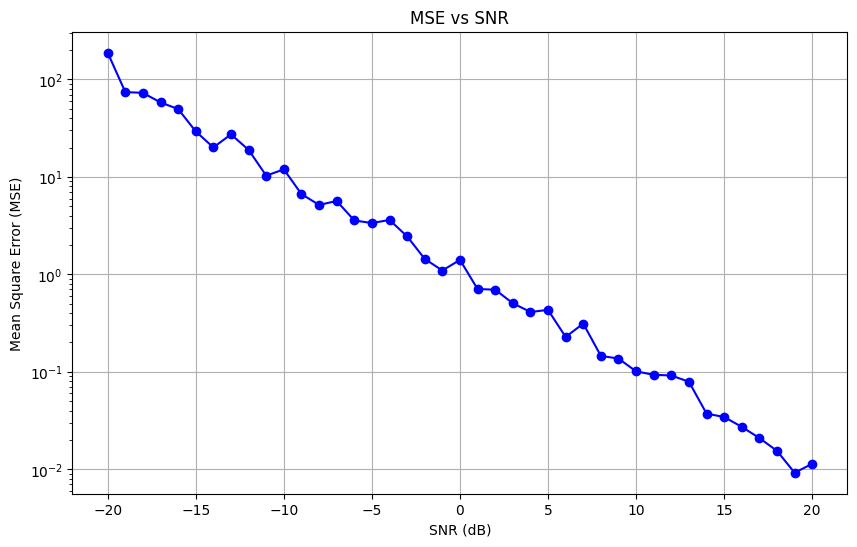

In [ ]:
# Sweep SNR from -20 to 20 dB
snr_levels = np.linspace(-20, 20, 41)
mses = []

for snr in snr_levels:
    noisy_measurements = add_noise_based_on_snr(principal_components, snr)
    estimated_states = weighted_low_rank_approximation(noisy_measurements)
    estimated_states_pca = pca.inverse_transform(estimated_states)
    reconstructed_estimates = scaler.inverse_transform(estimated_states_pca)
    mse = np.mean((true_states - reconstructed_estimates.T)**2)
    mses.append(mse)

# Plotting MSE vs SNR
plt.figure(figsize=(10, 6))
plt.plot(snr_levels, mses, marker='o', linestyle='-', color='b')
plt.yscale('log')  # Log scale for better visualization of MSE changes
plt.title('MSE vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Square Error (MSE)')
plt.grid(True)
plt.show()


# **GRAPH NEURL NETWORK (GNN)**

**First we create the data, then we adding Noise ~ $N(0,1)$.**

**After that, we create a PyTorch implementation for Graph Convolutional Network.**

In [ ]:
def add_noise_based_on_snr(signal, snr_db):
    signal_power = torch.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = torch.sqrt(noise_power) * torch.randn(signal.size())
    return signal + noise

# Function to generate graph data with node features (pressure and flow)
def generate_graph_data(num_nodes, snr_db):
    # Generate a random tree graph
    G = nx.erdos_renyi_graph(num_nodes,0.3)
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    # Generate random node features: pressures and flows
    pressures = np.random.rand(num_nodes)  # Pressure in psi
    flows = np.random.rand(num_nodes)     # Flow in m^3/h
    x = torch.tensor(np.vstack((pressures, flows)).T, dtype=torch.float)

    x_noisy = add_noise_based_on_snr(x, snr_db)

    return Data(x=x_noisy, edge_index=edge_index)


# # Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.dropout(x, p=0.2, train=self.training)
        # Second GCN layer
        x = self.conv2(x, edge_index)

        return x


In [ ]:
def train(data,num_features, hidden_channels, num_classes, lr=1e-3):
    # Initialize model and optimizer
    model = GCN(num_features, hidden_channels, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    criterion = torch.nn.MSELoss()  # Assuming a regression type problem

    losses = []
    model.train()
    for epoch in range(10000):  # Number of epochs
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out, data.x)  # Example: trying to predict the input itself as a placeholder
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # Store the loss for later visualization

        if epoch % 1000 == 0:
            print(f'Epoch {epoch} | Loss: {loss.item()}')

    # Plotting the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs. Epochs for SNR = {snr_db}')
    plt.legend()
    plt.grid(True)
    # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/MSE_LOSS2.pdf', bbox_inches='tight')
    plt.show()

    return 1


In [ ]:
# Parameters
num_nodes = 200
num_features = 2  # Pressure and Flow
hidden_channels = 16
num_classes = 2   # Output features, could be transformed as needed
snr_db = -10  # Low SNR condition

# Generate data
data = generate_graph_data(num_nodes, snr_db)


**Applying the Train function, that uses the MSE Loss function between the True states and the estimated states - after the GCN model.**
\begin{equation}
\text{MSE}_{loss} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
\end{equation}

Epoch 0 | Loss: 5.222494602203369
Epoch 1000 | Loss: 3.124849796295166
Epoch 2000 | Loss: 3.125869035720825
Epoch 3000 | Loss: 3.1107654571533203
Epoch 4000 | Loss: 3.0986316204071045
Epoch 5000 | Loss: 3.107090711593628
Epoch 6000 | Loss: 3.0987796783447266
Epoch 7000 | Loss: 3.081861972808838
Epoch 8000 | Loss: 3.080324411392212
Epoch 9000 | Loss: 3.091742753982544


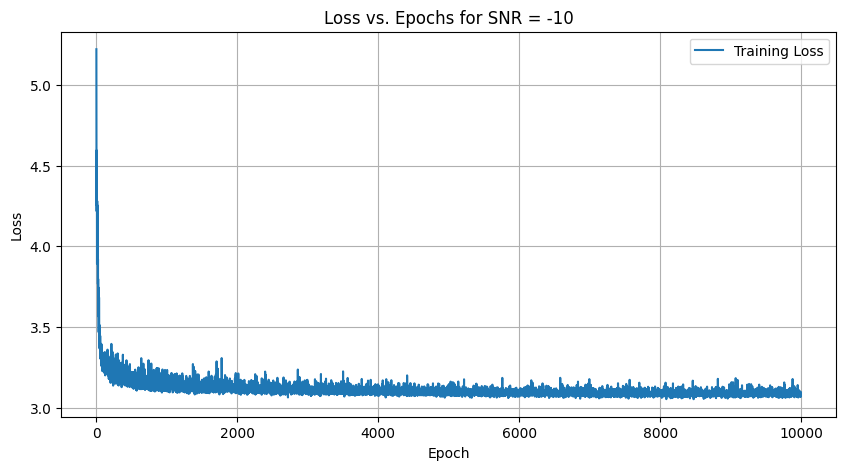

1

In [ ]:
train(data,num_features, hidden_channels, num_classes, 1e-3)

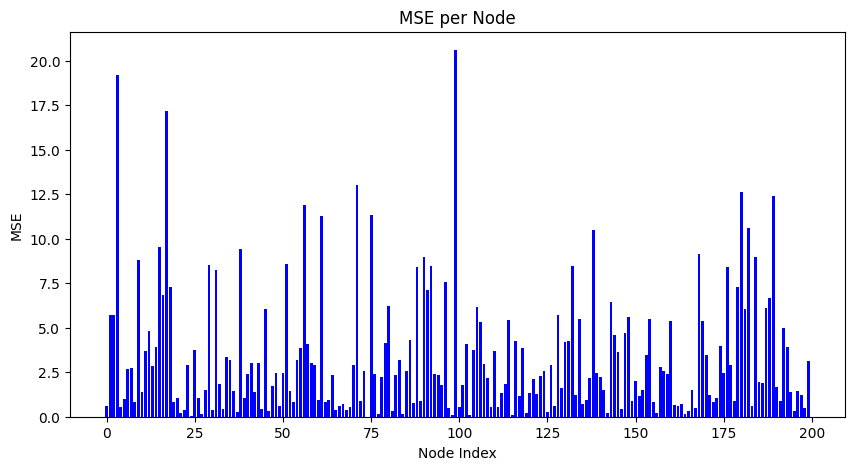

In [ ]:
model = GCN(num_features, hidden_channels, num_classes)
model.eval()
with torch.no_grad():
    pred = model(data)
    mse_per_node = ((pred - data.x) ** 2).mean(1).numpy()  # MSE per node

# Plotting MSE per node
plt.figure(figsize=(10, 5))
plt.bar(range(num_nodes), mse_per_node, color='blue')
plt.xlabel('Node Index')
plt.ylabel('MSE')
plt.title('MSE per Node')
plt.show()

# EKF_GSP

Implementation of EKF - GSP.

In [ ]:
def add_noise_based_on_snr(signal, snr_db):
    """ Adds noise to the signal based on the specified SNR in dB. """
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

In [ ]:
def generate_initial_state(num_nodes):
    pressures = np.random.randn(num_nodes)  # Normally distributed pressures
    flows = np.random.randn(num_nodes)      # Normally distributed flows
    return np.vstack((pressures, flows)).flatten()  # State vector of pressures followed by flows

def state_transition(x, L, dt=0.0001):
    """ More physically plausible state transition model for pressures and flows """
    num_nodes = len(x) // 2
    pressures, flows = x[:num_nodes], x[num_nodes:]

    # Pressure diffusion model: pressure equalizes over the graph based on Laplacian
    d_pressures_dt = -L @ pressures

    # Flow model: flows change based on pressure gradients
    d_flows_dt = -L @ (pressures - np.mean(pressures))

    new_pressures = pressures + dt * d_pressures_dt
    new_flows = flows + dt * d_flows_dt
    return np.hstack((new_pressures, new_flows))

def measurement_model(x):
    """ Nonlinear measurement model """
    pressures, flows = x[:len(x)//2], x[len(x)//2:]
    # return np.hstack((np.arctan(pressures), np.arctan(flows)))  # Simplified measurement
    return np.hstack((pressures, flows))  # Simplified measurement

In [ ]:
# Graph setup
num_nodes = 20
G = nx.random_tree(num_nodes)
L = nx.normalized_laplacian_matrix(G).toarray()  # Laplacian matrix

# Initialize state
x_true = generate_initial_state(num_nodes)
x_hat = np.random.randn(len(x_true))  # Initial estimate
P = np.eye(len(x_true))  # Initial covariance matrix

# Process and measurement noise covariances
Q = np.eye(len(x_true)) * 1  # Process noise covariance
R = np.eye(len(x_true)) * 2  # Measurement noise covariance

# SNR range and MSE storage
snr_range = np.linspace(-40, 10, 31)
mse_results = []

In [ ]:
for snr_db in snr_range:
    x_hat = np.random.randn(len(x_true))  # Reset initial estimate for each SNR level
    P = np.eye(len(x_true))  # Reset initial error covariance
    mse = []

    for t in range(100):  # Simulate over time steps
        # Simulate system
        x_true = generate_initial_state(num_nodes) #state_transition(x_true, L)
        y = x_true + add_noise_based_on_snr(np.zeros(len(x_true)), snr_db)

        # EKF Prediction
        A = np.eye(len(x_true))  # Placeholder for the Jacobian of the state transition
        x_pred = state_transition(x_hat, L)
        P_pred = A @ P @ A.T + Q

        # EKF Update
        H = np.eye(len(x_true))  # Placeholder for the Jacobian of the measurement model
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        x_hat = x_pred + K @ (y - measurement_model(x_pred))
        P = (np.eye(len(x_true)) - K @ H) @ P_pred

        # Calculate MSE
        mse.append(np.mean((x_true - x_hat)**2))

    mse_results.append(np.mean(mse))  # Average MSE over time for each SNR

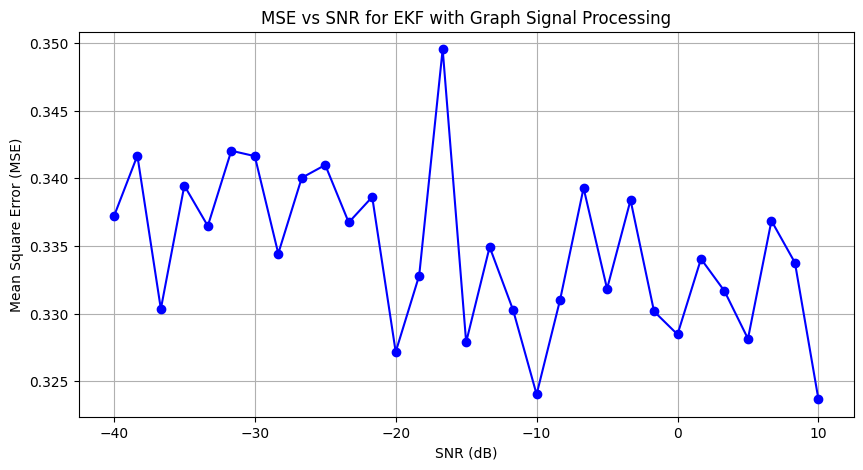

In [ ]:
# Plot MSE vs SNR
plt.figure(figsize=(10, 5))
plt.plot(snr_range, mse_results, marker='o', linestyle='-', color='blue')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Square Error (MSE)')
plt.title('MSE vs SNR for EKF with Graph Signal Processing')
plt.grid(True)
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GSP/figures/kalman.pdf', bbox_inches='tight')
plt.show()


In [ ]:
! pip install Presentation
! pip install Inches
from pptx import Presentation
from pptx.util import Inches
import os

# Summarize the paper
summary = """
SinGAN: Learning a Generative Model from a Single Natural Image

Introduction:
- SinGAN is a generative model trained on a single natural image, capable of learning internal statistics of the image.
- The model can generate high-quality, diverse samples and enables numerous image manipulation tasks.
- Unlike conventional GANs, SinGAN does not require a large dataset for training.

Key Concepts and Architecture:
- SinGAN leverages the internal patch distribution of a single image to learn its generative model.
- The model architecture consists of a pyramid of GANs, where each level of the pyramid captures image details at different scales.
- Training involves optimizing each GAN in the pyramid to generate realistic image patches.

Main Equations:
1. Adversarial Loss:
\[ L_{adv}(G, D) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)} [\log(1 - D(G(z)))] \]
2. Reconstruction Loss:
\[ L_{rec}(G) = \mathbb{E}_{x \sim p_{data}(x)} [\|x - G(x)\|_1] \]

Results:
- SinGAN generates high-quality images and outperforms traditional GANs in tasks such as super-resolution, harmonization, editing, and paint-to-image.
- Qualitative results demonstrate the model's ability to generate diverse and realistic images from a single training image.

Conclusion:
- SinGAN opens new possibilities for image generation and manipulation by learning from a single image.
- The model is versatile and can be applied to various image synthesis and editing tasks without requiring a large dataset.

References:
- [1] SinGAN: Learning a Generative Model from a Single Natural Image. https://arxiv.org/abs/1905.01164
"""

# Initialize presentation
prs = Presentation()

# Title slide
slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "SinGAN: Learning a Generative Model from a Single Natural Image"
subtitle.text = "Summary and Key Highlights"

# Content slides
content = summary.strip().split("\n\n")
for section in content:
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)
    title_shape, content_shape = slide.shapes.title, slide.placeholders[1]
    title_text, content_text = section.split(":\n", 1)
    title_shape.text = title_text
    tf = content_shape.text_frame
    for paragraph in content_text.strip().split("\n- "):
        if paragraph:
            p = tf.add_paragraph()
            p.text = paragraph
            p.level = 1

# Adding figures slide
figures_slide = prs.slide_layouts[5]
slide = prs.slides.add_slide(figures_slide)
title = slide.shapes.title
title.text = "Results and Visuals"
textbox = slide.placeholders[1].text_frame
textbox.text = "Qualitative results demonstrating the model's ability to generate diverse and realistic images from a single training image."

# Adding figures (example figures, replace with actual figures as necessary)
figures = ["/mnt/data/cmpr3models.pdf", "/mnt/data/cmprkalman.pdf", "/mnt/data/MSE_LOSS.pdf"]
for figure in figures:
    slide = prs.slides.add_slide(figures_slide)
    title = slide.shapes.title
    title.text = "Figure"
    pic = slide.shapes.add_picture(figure, Inches(1), Inches(1.5), width=Inches(8))

# Save the presentation
presentation_path = "/mnt/data/SinGAN_Presentation_Final.pptx"
prs.save(presentation_path)

presentation_path


ERROR: Could not find a version that satisfies the requirement Presentation (from versions: none)
ERROR: No matching distribution found for Presentation
ERROR: Could not find a version that satisfies the requirement Inches (from versions: none)
ERROR: No matching distribution found for Inches


ModuleNotFoundError: No module named 'pptx'